# Non linear analysis - Assignment 4

29.10.2023 - Jérémie Engler and Laure Toullier

In [60]:
#imports

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import math
import pandas as pd

np.set_printoptions(precision=5, suppress=True, linewidth=150)

Params = plt.rcParams
Params['figure.figsize'] = (14, 7) 

---

# Euler forward method

General data

In [61]:
E = 200e3 #Mpa
poisson = 0
sigma_y = 400 #Mpa

eps_0 = np.zeros((2,))
sigma_0 = np.zeros((2,))

strain_incr = np.array([0.003,0.004])

d = E/(1 - poisson**2) #Factor of the constitutive matrix

D = np.full((2,2), poisson)
np.fill_diagonal(D, 1)
D = D * d

In [168]:
def stress_incr_computation(strain_incr, plastic_strain_incr, n, D):
    if plastic_strain_incr.all() == 0:
        stress_incr = D @ strain_incr
    else:
        stress_incr = (D - (D @ n.T @ n @ D) / (n @ D @ n.T)) @ plastic_strain_incr
        correction_factor = (D @ n.T @ n @ D) / (n @ D @ n.T)
        trial_factor = D

    return stress_incr

def stress_for_initial_strain(strain_incr, D): # Stress increment from strain increment
    plastic_strain_incr = np.zeros((2,))
    n = np.zeros((2,))

    # First forward step

    stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

    stress_0 = sigma_0 + stress_incr

    return stress_0

def check_failure(stress):
    fail = False
    criterion = stress[0]**2 + stress[1]**2 - stress[0] * stress[1] - sigma_y ** 2

    if criterion > 0:
        fail = True

    return fail

def failure_value(stress_tamp):
    criterion = stress_tamp[0]**2 + stress_tamp[1]**2 - stress_tamp[0] * stress_tamp[1] - sigma_y ** 2

    return criterion

def strain_decomposition(strain_incr, alpha):
    elastic_strain_incr = alpha * strain_incr
    plastic_strain_incr = (1 - alpha) * strain_incr

    return elastic_strain_incr, plastic_strain_incr

def norm_criterion_surface(stress_y):
    n1 = 2 * stress_y[0] - stress_y[1]
    n2 = 2 * stress_y[1] - stress_y[0]
    n = np.array([[n1,n2]])
    return n

def printgraph(x,y,xname,yname,unit1, unit2, additionnal_title = None, noscale = False):
    plt.figure(figsize=(10, 8))
    plt.plot(x,y,'o')
    # plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}' + additionnal_title)
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")
    if noscale == False:
        plt.xlim(0,)
        plt.ylim(0,)
    plt.show()

    return None

def fcriterion(sigma_y):
    # x = np.linspace(0, 1000, 10000)
    # y = np.linspace(0, 1000, 10000)
    # crit_points_x = []
    # crit_points_y = []
    # for i in range(len(x)):
    #     criterion = x[i]**2 + y[i]**2 - x[i] * y[i] - sigma_y ** 2
    #     if abs(criterion) < 100:
    #         crit_points_x.append(x[i])
    #         crit_points_y.append(y[i])
    #         print(x[i],y[i])
    x = np.linspace(-500, 500, 1000)
    y1 = np.linspace(-500, 500, 1000)
    y2 = np.linspace(-500, 500, 1000)
    crit_points_x = []
    crit_points_y1 = []
    crit_points_y2 = []
    for i in range(len(x)):
        y1[i] = (x[i] + np.sqrt(x[i]**2 - 4*(x[i]**2 - sigma_y**2)))/2
        y2[i] = (x[i] - np.sqrt(x[i]**2 - 4*(x[i]**2 - sigma_y**2)))/2
        crit_points_x.append(x[i])
        crit_points_y1.append(y1[i])
        crit_points_y2.append(y2[i])

    return crit_points_x, crit_points_y1, crit_points_y2

def printgraph_with_yield_func(x,y,xname,yname,unit1, unit2, sigma_y, additionnal_title = None):
    crit_points_x, crit_points_y1, crit_points_y2 = fcriterion(sigma_y)
    axe_x = np.linspace(-1000,1000,1000)
    axe_y = np.linspace(-1000,1000,1000)
    null = np.zeros(1000)

    plt.figure(figsize=(10, 8))

    plt.plot(crit_points_x,crit_points_y1, color = "darkgray", label = "Von mises yield criterion")
    plt.plot(crit_points_x,crit_points_y2, color = "darkgray")
    plt.plot(axe_x,null, color = "black")
    plt.plot(null,axe_y, color = "black")
    plt.plot(x,y,'o', label = 'Forward Euler')
    plt.plot(x,y,'b')
    
    plt.title(f'{yname} as a function of {xname}' + additionnal_title)
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")
    plt.xlim(-100,900)
    plt.ylim(-100,900)

    plt.legend()

    plt.show()

    return None


## Steps 1 and 2

In [173]:
# Step 1

stress_0 = stress_for_initial_strain(strain_incr, D)

print(f"Stress 0 = {stress_0}")

if check_failure(stress_0) == True:
    alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
    stress_y = alpha * stress_0

elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)

stress = stress_y

n = norm_criterion_surface(stress)

stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

stress = stress + stress_incr

print(f"Stress with 1 sub-increments: {stress} Mpa")
print(f"Criterion value = {failure_value(stress)}")

stress_step_1 = stress
criterion_step_1 = failure_value(stress)

Stress 0 = [600. 800.]
Stress with 1 sub-increments: [440.30628 400.76569] Mpa
Criterion value = 18023.108205810888


In [170]:
# Step 2

stress_0 = stress_for_initial_strain(strain_incr, D)

if check_failure(stress_0) == True:
    alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
    stress_y = alpha * stress_0

elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)

plastic_strain_incr_2 = plastic_strain_incr / 2

stress = stress_y

for sub_increment in range(2):
    n = norm_criterion_surface(stress)

    stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr_2, n, D)

    stress = stress + stress_incr

    print(f"Stress, sub-increment {sub_increment + 1}: {stress} Mpa \n")

print(f"Stress with 2 sub-increments: {stress} Mpa")
print(f"Criterion value = {failure_value(stress)}")

stress_step_2 = stress
criterion_step_2 = failure_value(stress)

Stress, sub-increment 1: [386.5632  422.26293] Mpa 

Stress, sub-increment 2: [384.75167 423.65081] Mpa 

Stress with 2 sub-increments: [384.75167 423.65081] Mpa
Criterion value = 4513.499097270338


## Step 3

In [171]:
def first_step(): # Function doing the part 1 and 2 of the assignment

    # Stress increment from strain increment

    stress_0 = stress_for_initial_strain(strain_incr, D)

    if check_failure(stress_0) == True:
        alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
        stress_y = alpha * stress_0

    elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)


    # Second forward step

    plastic_strain_incr_2 = plastic_strain_incr / 2

    stress = stress_y

    for sub_increment in range(2):
        n = norm_criterion_surface(stress)

        stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr_2, n, D)

        stress = stress + stress_incr
        
    return stress, stress_y, stress_0, plastic_strain_incr, n

def forward_euler(sub_increments):

    plastic_strain_incr = np.zeros((2,))
    n = np.zeros((2,))

    # First forward step

    stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

    stress_0 = sigma_0 + stress_incr

    print(f"Stress at first step: {stress_0} Mpa ")

    if check_failure(stress_0) == True:
        alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
        stress_y = alpha * stress_0

    else:
        raise ValueError("First step too small: yielding not reached")

    print(f"Criterion value at first step = {failure_value(stress_y)}")
    print(f"Yielding stress at first step: {stress_y} Mpa \n")

    elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)


    # Next forward steps

    plastic_strain_incr_2 = plastic_strain_incr / sub_increments

    print(f"Plastic strain increment = {plastic_strain_incr}")
    print(f"Plastic strain sub_increment = {plastic_strain_incr_2} \n")

    stress = stress_y

    for sub_increment in range(sub_increments):
        n = norm_criterion_surface(stress)
        print(f'n{sub_increment} = {n}')

        stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr_2, n, D)
        print(f"Δσ{sub_increment + 1} = {stress_incr}")

        stress = stress + stress_incr
        
        print(f"Stress, sub-increment {sub_increment + 1}: {stress} Mpa \n")

    print(f"Stress with {sub_increments} sub-increments: {stress} Mpa")
    print(f"Criterion value = {failure_value(stress)}")

    return stress, failure_value(stress)

def forward_euler_without_print(sub_increments, final_print = False):

    stresses_1 = []
    stresses_2 = []

    plastic_strain_incr = np.zeros((2,))
    n = np.zeros((2,))

    # First forward step

    stress_incr_0 = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

    stress_0 = sigma_0 + stress_incr_0

    stresses_1.append(stress_0[0])
    stresses_2.append(stress_0[1])

    if check_failure(stress_0) == True:
        alpha = np.sqrt((sigma_y**2) / (stress_0[0]**2 + stress_0[1]**2 - stress_0[0] * stress_0[1]))
        stress_y = alpha * stress_0

    else:
        raise ValueError("First step too small: yielding not reached")

    elastic_strain_incr, plastic_strain_incr = strain_decomposition(strain_incr, alpha)

    # Next forward steps

    plastic_strain_incr_2 = plastic_strain_incr / sub_increments

    stress = stress_y

    for sub_increment in range(sub_increments):
        n = norm_criterion_surface(stress)

        stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr_2, n, D)

        stress = stress + stress_incr

        stresses_1.append(stress[0])
        stresses_2.append(stress[1])

    if final_print == True:
        print(f"Stress with {sub_increments} sub-increments: {stress} Mpa")
        print(f"Criterion value = {failure_value(stress)} \n")

    if final_print == True:
        printgraph_with_yield_func(stresses_1, stresses_2, "Stress 1", "Stress 2", "Mpa", "Mpa", sigma_y, f", forward Euler, one step, {sub_increments} sub-increments")

    return stress, failure_value(stress)

Stress with 125 sub-increments: [375.25938 420.91288] Mpa
Criterion value = 35.751173254539026 



/var/folders/65/sg51ysjx6bs0_4zwxy6345nw0000gn/T/ipykernel_23030/4248202528.py:82: RuntimeWarning: invalid value encountered in sqrt
  y1[i] = (x[i] + np.sqrt(x[i]**2 - 4*(x[i]**2 - sigma_y**2)))/2
/var/folders/65/sg51ysjx6bs0_4zwxy6345nw0000gn/T/ipykernel_23030/4248202528.py:83: RuntimeWarning: invalid value encountered in sqrt
  y2[i] = (x[i] - np.sqrt(x[i]**2 - 4*(x[i]**2 - sigma_y**2)))/2


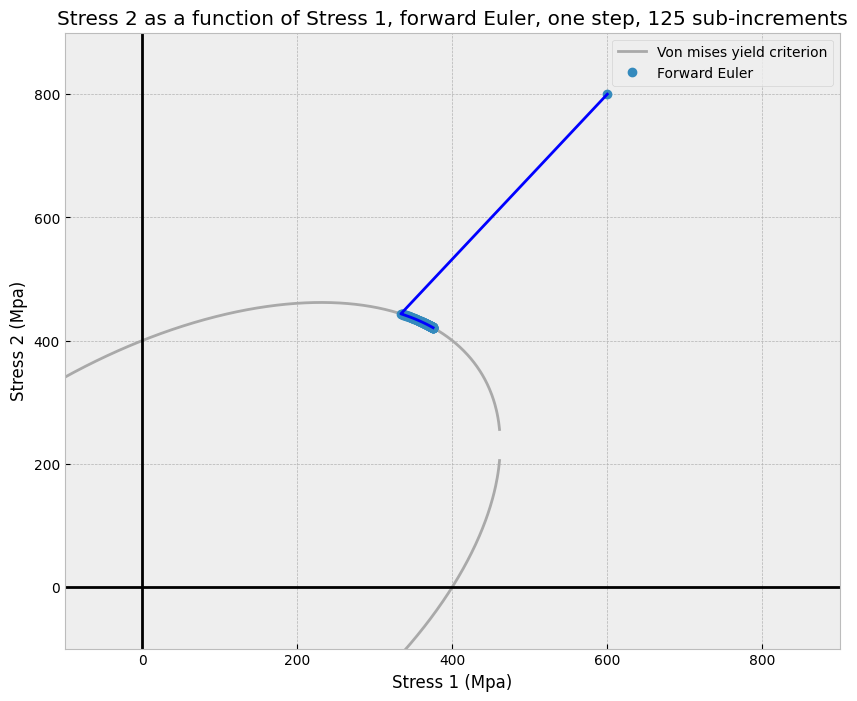

Stress with 124 sub-increments: [375.26045 420.91275] Mpa
Criterion value = 36.04198918849579 



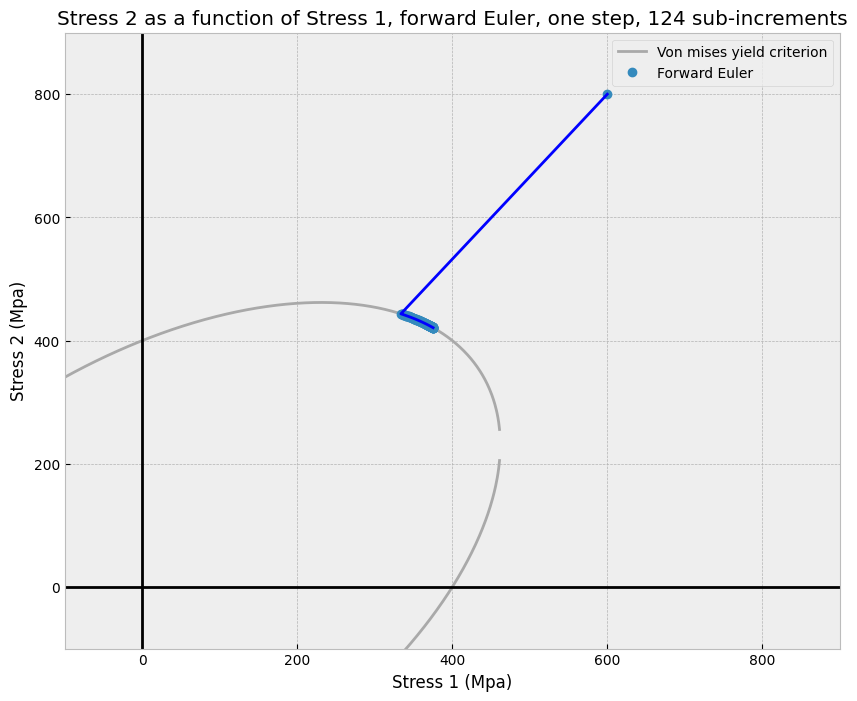

In [185]:
forward_euler_without_print(125, True) #With 125, criterion smaller than error tolerance (see next cell)

forward_euler_without_print(124, True)

stress_step_3, criterion_step_3 = forward_euler_without_print(125)

### Find the minimum number of sub-increments automatically:

Acceptable error = 36.0 

Minimum number of sub-increments = 125, failure value = 35.751173254539026


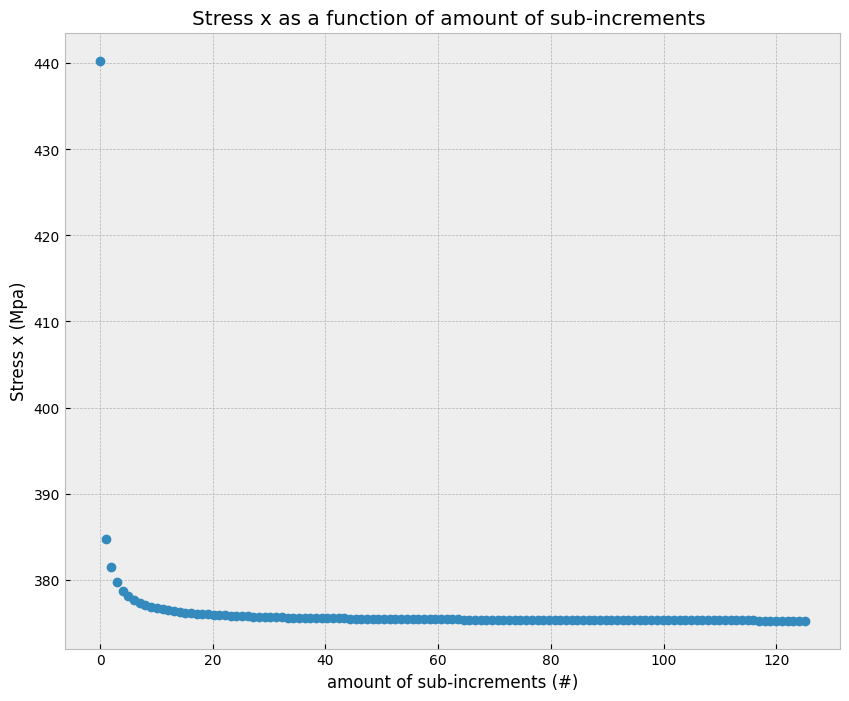

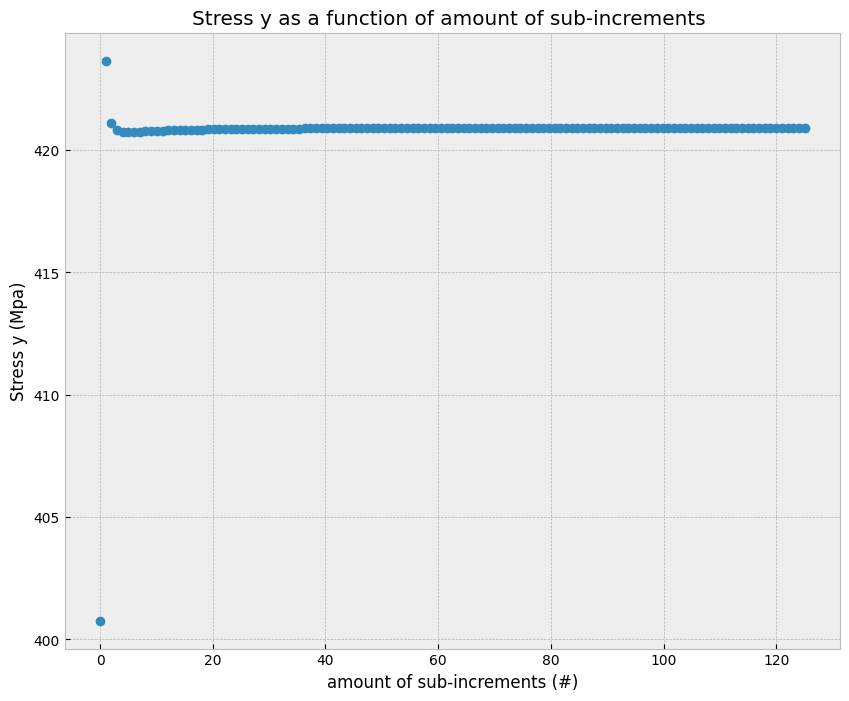

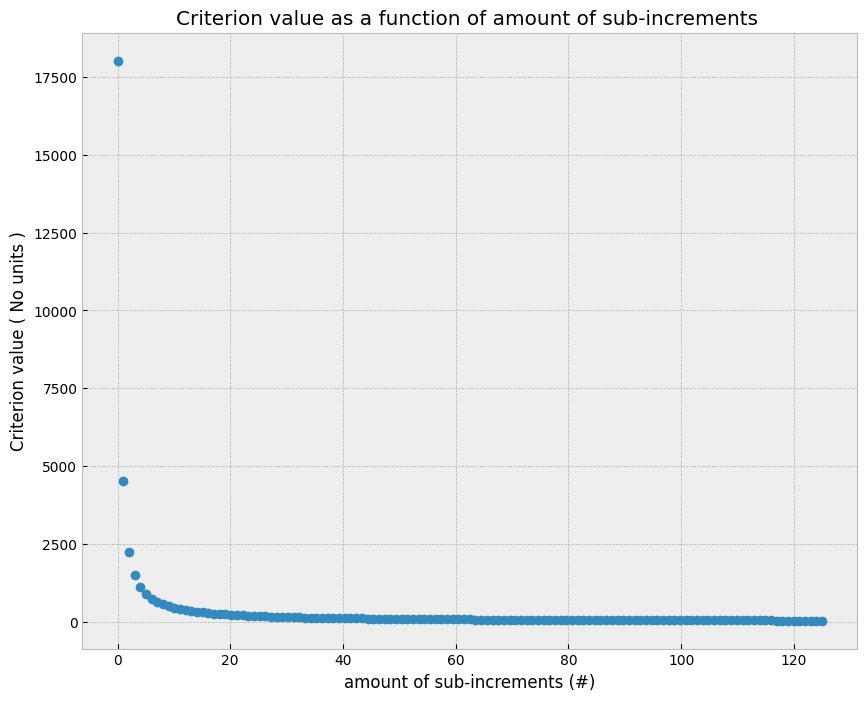

In [183]:
def minimum_sub_incr_non_optimal_finder(error):
    print(f"Acceptable error = {error} \n")
    
    stresses_x = []
    stresses_y = []
    failure_values = []

    sub_increments = 0
    failure_value_i = error * 2

    while failure_value_i > error:  
        sub_increments = sub_increments + 1
        # print(f"Sub-increment = {sub_increments}")

        stress_i, failure_value_i = forward_euler_without_print(sub_increments)

        stresses_x.append(stress_i[0])
        stresses_y.append(stress_i[1])
        failure_values.append(failure_value_i)
        # print(f"Failure value with {sub_increments} sub-increments: {failure_value_i} \n")

    print(f"Minimum number of sub-increments = {sub_increments}, failure value = {failure_value_i}")

    return stresses_x, stresses_y, failure_values, sub_increments

error = failure_value(stress_for_initial_strain(strain_incr, D)) / 1e4

stresses_x, stresses_y, failure_values, sub_increments = minimum_sub_incr_non_optimal_finder(error)
x = np.linspace(0,sub_increments,sub_increments)
printgraph(x, stresses_x,  "amount of sub-increments", "Stress x", "#", "Mpa", " ", noscale = True)
printgraph(x, stresses_y,  "amount of sub-increments", "Stress y", "#", "Mpa", " ", noscale = True)
printgraph(x, failure_values,  "amount of sub-increments", "Criterion value", "#", " No units ", " ", noscale = True)

## Post processing

In [182]:
print(f"Step 1: stress = {stress_step_1}, criterion = {criterion_step_1} \n")
print(f"Step 2: stress = {stress_step_2}, criterion = {criterion_step_2} \n")
print(f"Step 3: stress = {stress_step_3}, criterion = {criterion_step_3} \n")

Step 1: stress = [440.30628 400.76569], criterion = 18023.108205810888 

Step 2: stress = [384.75167 423.65081], criterion = 4513.499097270338 

Step 3: stress = [375.25938 420.91288], criterion = 35.751173254539026 



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Euler Backward method

# Step 4

General data

In [10]:
E = 200e3 #Mpa
poisson = 0

eps_0 = np.zeros((2,))
sigma_0 = np.zeros((2,))
sigma_y=400.0 #yield stress in MPa

strain_incr = np.array([0.003,0.004])

#Constitutive matrix for plane stress:
d = E/(1 - poisson**2) #Factor of the constitutive matrix

D = np.full((2,2), poisson)
np.fill_diagonal(D, 1)
D = D * d
print(D)

[[200000.      0.]
 [     0. 200000.]]


Plane condition

In [11]:
def stress_incr_computation(strain_incr, plastic_strain_incr, n, D):
    if plastic_strain_incr.all() == 0:
        stress_incr = D @ strain_incr
    else:
        stress_incr = (D - (D @ n.T @ n @ D) / (n @ D @ n.T)) @ plastic_strain_incr
        correction_factor = (D @ n.T @ n @ D) / (n @ D @ n.T)
        trial_factor = D

    return stress_incr


def stress_for_initial_strain(strain_incr, D): # Stress increment from strain increment
    plastic_strain_incr = np.zeros((2,))
    n = np.zeros((2,))

    # First forward step

    stress_incr = stress_incr_computation(strain_incr, plastic_strain_incr, n, D)

    stress_0 = sigma_0 + stress_incr

    return stress_0

def strain_decomposition(strain_incr, alpha):
    elastic_strain_incr = alpha * strain_incr
    plastic_strain_incr = (1 - alpha) * strain_incr
    total_strain_incr=elastic_strain_incr+plastic_strain_incr

    return elastic_strain_incr, plastic_strain_incr,total_strain_incr

Von Mises yield criterion

In [12]:
def f (vector, sigma_y):
    fa=vector[0]**2+vector[1]**2-vector[0]*vector[1]-sigma_y**2
    return fa

Trial stress increment

In [13]:
#stress trial

def stress_trial (stress,D, strain_incr):
    stress_trial_=stress+D@strain_incr
    return stress_trial_

In [14]:
#test trial
strial=stress_trial (sigma_0,D, strain_incr)
f_trial=f(strial, sigma_y)
stress_0=strial
f0=f_trial
print(f'strial={strial}')
print(f'ftrial={f_trial}')

strial=[600. 800.]
ftrial=360000.0


In [15]:
#check of failure condition
if f_trial<0:
    print("Elastic state for the trial stress increment")
if f_trial==0:
    print("Failure at trial stress increment")
else:
    print("Not acceptable, plastic deformations occur ")
    alpha=np.sqrt((sigma_y**2)/(strial[0]**2+strial[1]**2-strial[0]*strial[1]))
    elastic_strain_incr, plastic_strain_incr,total_strain_incr=strain_decomposition(strain_incr, alpha)
   
print(f'elastic strain={elastic_strain_incr}')
print(f'plastic strain={plastic_strain_incr}')
print(f'total strain={total_strain_incr}')


Not acceptable, plastic deformations occur 
elastic strain=[0.00166 0.00222]
plastic strain=[0.00134 0.00178]
total strain=[0.003 0.004]


Euler backward method

In [16]:
#f derivated by stress (gradient of the yield surface)

def norm_criterion_surface(stress):
    n=np.zeros((2))
    n[0] = 2 * stress[0] - stress[1]
    n[1] = 2 * stress[1] - stress[0]
    return n

In [17]:
#stress derived by incr_lambda

def fd_stress_d_lambda (E, stress, incr_lambda):
    ds_dl=np.zeros((2))
    ds_dl[0]= (E*(stress[1]-3*(E**2)*stress[1]*(incr_lambda**2)-2*stress[0]*(1+3*E*incr_lambda*(1+E*incr_lambda)))/(((1+E*incr_lambda)**2)*(1+3*E*incr_lambda)**2))
    ds_dl[1]= (E*(stress[0]-3*(E**2)*stress[0]*(incr_lambda**2)-2*stress[1]*(1+3*E*incr_lambda*(1+E*incr_lambda)))/(((1+E*incr_lambda)**2)*(1+3*E*incr_lambda)**2))
    return ds_dl

In [18]:
#f derivated by incr_lamba using a scalar product (we get an integer)

def f_derivated_lambda (d_stress_d_lambda, d_f_d_stress):
    #f_d=d_stress_d_lambda[0]*d_f_d_stress[0,0]+d_stress_d_lambda[1]*d_f_d_stress[0,1]
    f_d=np.dot(d_f_d_stress,d_stress_d_lambda)
    return f_d

In [19]:
#increment of lambda i

def fincr_lambda_i (incr_lambda, f_d_lambda, f_of_incr_lambda):
    incr_lambda_i=incr_lambda-f_of_incr_lambda/f_d_lambda
    return incr_lambda_i

In [20]:
#stress vector at the end of the iteration i

def fstress_vector_i (stress, E, incr_lambda_i):
    stress_i=np.zeros((2))
    stress_i[0]=(stress[0]+E*incr_lambda_i*(stress[1]+2*stress[0]))/((1+E*incr_lambda_i)*(1+3*E*incr_lambda_i))
    stress_i[1]=(stress[1]+2*E*incr_lambda_i*stress[1]+E*incr_lambda_i*stress[0])/(1+4*E*incr_lambda_i+3*(E**2)*(incr_lambda_i**2))
    return stress_i

In [21]:
n=norm_criterion_surface(stress_0).reshape((2,1))
incr_lambda=(D @ n @ n.T @ D) / (n.T @ D @ n) @ plastic_strain_incr

In [22]:
#to print later
sigma1=[]
sigma2=[]

In [23]:
#Initialisation
stress=stress_0
incr_lambda_i=float(0)

sigma1.append(stress_0[0])
sigma2.append(stress_0[1])

iteration=20 #nb of iteration

#for each step i:

for i in range(iteration):

    stress_previous=stress
    incr_lambda_previous=incr_lambda_i
    
    #at step i-1
    d_f_d_stress_=norm_criterion_surface (stress_0)
    d_stress_d_lambda=fd_stress_d_lambda(E, stress_0, incr_lambda_previous)
    d_f_d_lambda=f_derivated_lambda(d_stress_d_lambda, d_f_d_stress_)
    f_lambda=f(stress_previous, sigma_y)
    
    #at step i
    incr_lambda_i=fincr_lambda_i (incr_lambda_previous, d_f_d_lambda, f_lambda)
    stress=fstress_vector_i (stress_0, E, incr_lambda_i)
    fy=f(stress,sigma_y)
    print("----")
    print(f'incr_lambda={incr_lambda_i}')
    print(f'stress={stress}')
    print(f'fy={fy}')
    print("----")

    sigma1.append(stress[0])
    sigma2.append(stress[1])

    #n=norm_criterion_surface (stress).reshape((2,1))
    #incr_lambda=(D @ n @ n.T @ D) / (n.T @ D @ n) @ plastic_strain

    if fy/f_trial < 0.0001:
        print ("Convergence is reached at step ", i)
        print(f'stress={stress}')
        print(f'fy={fy}')
        break

    if i==iteration and fy/f_trial>0.0001:
        raise ValueError("No convergence !")
 


----
incr_lambda=1.5517241379310346e-06
stress=[482.42481 585.99624]
fy=133426.16703883774
----
----
incr_lambda=2.6294216810289537e-06
stress=[419.95539 497.54535]
fy=54967.05138132212
----
----
incr_lambda=3.2429004812131066e-06
stress=[390.6605  458.55514]
fy=23749.062833355274
----
----
incr_lambda=3.554300564510527e-06
stress=[377.22836 441.07349]
fy=10461.631009876524
----
----
incr_lambda=3.7024185850521453e-06
stress=[371.14513 433.22895]
fy=4645.218492568354
----
----
incr_lambda=3.770559539838456e-06
stress=[368.40945 429.71522]
fy=2069.547992574662
----
----
incr_lambda=3.801410163489443e-06
stress=[367.18361 428.14349]
fy=923.3786999341683
----
----
incr_lambda=3.815274913380242e-06
stress=[366.63525 427.44095]
fy=412.2531185806438
----
----
incr_lambda=3.8214851064310565e-06
stress=[366.39014 427.12704]
fy=184.10780786079704
----
----
incr_lambda=3.824262539956316e-06
stress=[366.28062 426.9868 ]
fy=82.23103633735445
----
----
incr_lambda=3.825503874884392e-06
stress=[366.

In [24]:
def printgraph(x,y,xname,yname,unit1, unit2):
    plt.figure(figsize=(7, 5))
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')
 

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

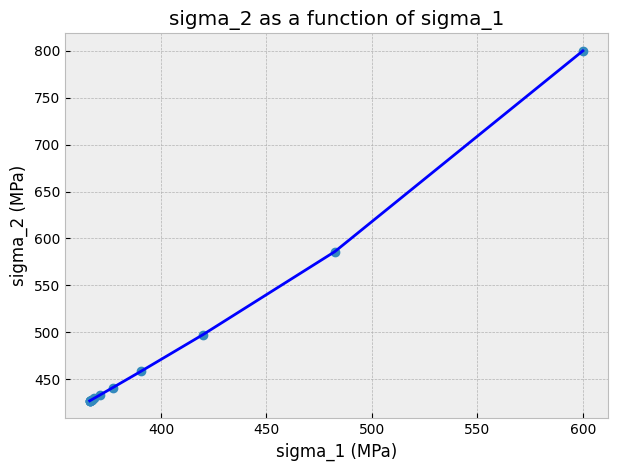

In [25]:
printgraph(sigma1,sigma2,"sigma_1","sigma_2","MPa","MPa")
